# Data reduction and visualization

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("../common")

from dataset import load_trainval, LC_TARGET_LABELS, TARGET_LABELS_FRQ, TARGET_LABELS_DIFF
from utils import to_yearmonth, TARGET_LABELS, TARGET_LABELS2
from utils import target_str_to_labels, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices

In [4]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

In [5]:
# # train_yearmonths_list = [201504, 201505, 201604]
# train_yearmonths_list = [201505, 201602, 201605]
# # train_yearmonths_list = [201505]
# #val_yearmonth = [201605]
# train_nb_clients = 150000
# # train_nb_clients = 1500
# #train_df, val_df = load_trainval(train_yearmonths_list, val_yearmonth, train_nb_clients, val_nb_clients=1500)
# train_df = load_trainval(train_yearmonths_list, train_nb_clients=train_nb_clients)
filename = "trainval_201505+201602+201605__150000.csv"
train_df = pd.read_csv('../data/generated/' + filename)

Display loaded data

In [6]:
train_df[['fecha_dato', 'ncodpers'] + TARGET_LABELS_FRQ.tolist()].head(10)

,fecha_dato,ncodpers,ind_ahor_fin_ult1_frq,ind_aval_fin_ult1_frq,ind_cco_fin_ult1_frq,ind_cder_fin_ult1_frq,ind_cno_fin_ult1_frq,ind_ctju_fin_ult1_frq,ind_ctma_fin_ult1_frq,ind_ctop_fin_ult1_frq,...,ind_hip_fin_ult1_frq,ind_plan_fin_ult1_frq,ind_pres_fin_ult1_frq,ind_reca_fin_ult1_frq,ind_tjcr_fin_ult1_frq,ind_valo_fin_ult1_frq,ind_viv_fin_ult1_frq,ind_nomina_ult1_frq,ind_nom_pens_ult1_frq,ind_recibo_ult1_frq
0,2015-04-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
1,2015-05-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
2,2016-01-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
3,2016-02-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
4,2016-04-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
5,2016-05-28,15890,0.999858,0.999964,0.228342,0.999447,0.102739,0.988305,0.989655,0.834099,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
6,2015-04-28,15893,0.999858,0.999964,0.228342,0.999447,0.897261,0.988305,0.989655,0.834099,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.033123,0.995205,0.933204,0.927901,0.840168
7,2015-05-28,15893,0.999858,0.999964,0.228342,0.999447,0.897261,0.988305,0.989655,0.834099,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.033123,0.995205,0.933204,0.927901,0.840168
8,2016-01-28,15893,0.999858,0.999964,0.228342,0.999447,0.897261,0.988305,0.989655,0.834099,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.033123,0.995205,0.933204,0.927901,0.840168
9,2016-02-28,15893,0.999858,0.999964,0.228342,0.999447,0.897261,0.988305,0.989655,0.834099,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.033123,0.995205,0.933204,0.927901,0.840168


Useful structures

In [7]:
def get_common_clients(df1, mask1, mask2, df2=None):
    active_clients1 = df1[mask1]['ncodpers'].unique()
    if df2 is not None:
        active_clients2 = df2[mask2]['ncodpers'].unique()
    else:
        active_clients2 = df1[mask2]['ncodpers'].unique()
    active_clients = list(set(active_clients1) & set(active_clients2)) 
    
    if df2 is not None:
        return df1['ncodpers'].isin(active_clients), df2['ncodpers'].isin(active_clients)
    return df1['ncodpers'].isin(active_clients)

In [8]:
months_ym_map = {}
# months = list(set(train_df['fecha_dato'].unique()) | set(val_df['fecha_dato'].unique()))
months = train_df['fecha_dato'].unique()
for m in months:
    months_ym_map[to_yearmonth(m)] = m

        
train_months = train_df['fecha_dato'].unique()
# val_months = val_df['fecha_dato'].unique()
    

### Train a model

In [9]:
from utils import get_added_products, remove_last_choice, apk, map7_score
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

In [10]:
target_features = ['targets_diff', 'targets_logdiff', 'targets_logcount2_diff', 'targets_logcount2', 'targets_logcount1', 'targets_logDec']
TARGET_LABELS_FRQ_PREV = [c + '_prev' for c in TARGET_LABELS_FRQ]

In [11]:
def get_XY(current_month, df1, next_year_month, df2, months_ym_map):
    month_mask = df1['fecha_dato'] == months_ym_map[current_month]
    next_year_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month]
    next_year_prev_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month - 1]
    
    # get common clients from df1 at this month and df2 at next year month
    common_clients_mask1, common_clients_mask2 = get_common_clients(df1, month_mask, next_year_month_mask, df2)
    common_clients_mask2, common_clients_mask3 = get_common_clients(df2, common_clients_mask2 & next_year_month_mask, next_year_prev_month_mask, df2)
        
    c1 = df1[common_clients_mask1 & month_mask]['ncodpers'].values
    c2 = df2[common_clients_mask2 & next_year_month_mask]['ncodpers'].values
    c3 = df2[common_clients_mask3 & next_year_prev_month_mask]['ncodpers'].values
    assert (c1 == c2).all() and (c2 == c3).all(), "Problem with common clients" 
    
    X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features + TARGET_LABELS_FRQ.tolist()]            
   
    if TARGET_LABELS[0] in df2.columns and TARGET_LABELS_DIFF[0] in df2.columns and not df2[next_year_month_mask][TARGET_LABELS].isnull().all().all():
        Y = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str', 'lc_targets_str', 'targets_diff'] + TARGET_LABELS + TARGET_LABELS_DIFF.tolist()]    
        assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
        Y.index = X.index                
    else:
        Y = None
        
    if TARGET_LABELS_FRQ[0] in df2.columns and not df2[next_year_prev_month_mask][TARGET_LABELS].isnull().all().all():
        # Add TARGET_LABELS_FRQ from previous month to X:
        target_labels_frq = df2[common_clients_mask3 & next_year_prev_month_mask][['ncodpers'] + TARGET_LABELS_FRQ.tolist()]
        assert (X['ncodpers'].values == target_labels_frq['ncodpers'].values).all(), "There is a problem in alignment"
        target_labels_frq = target_labels_frq[TARGET_LABELS_FRQ]
        target_labels_frq.columns = TARGET_LABELS_FRQ_PREV
        target_labels_frq.index = X.index
        X = pd.concat([X, target_labels_frq], axis=1)        

    
    if LC_TARGET_LABELS[0] in df2.columns:
        clients_last_choice = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str'] + LC_TARGET_LABELS.tolist()]
    else:
        clients_last_choice = None
        
    return X, Y, clients_last_choice


In [12]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_df if months_ym_map[current_month] in train_months else val_df
#df1 = train_df
df2 = train_df if months_ym_map[next_year_month] in train_months else val_df
#df2 = train_df

X, Y, clients_last_choice = get_XY(current_month, df1, next_year_month, df2, months_ym_map)

In [13]:
assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "WTF"
assert (X['ncodpers'].values == clients_last_choice['ncodpers'].values).all(), "WTF"

In [14]:
print X.shape
X.head(10)

(149980, 75)


,ncodpers,fecha_dato,targets_diff,targets_logdiff,targets_logcount2_diff,targets_logcount2,targets_logcount1,targets_logDec,ind_empleado,pais_residencia,...,ind_hip_fin_ult1_frq_prev,ind_plan_fin_ult1_frq_prev,ind_pres_fin_ult1_frq_prev,ind_reca_fin_ult1_frq_prev,ind_tjcr_fin_ult1_frq_prev,ind_valo_fin_ult1_frq_prev,ind_viv_fin_ult1_frq_prev,ind_nomina_ult1_frq_prev,ind_nom_pens_ult1_frq_prev,ind_recibo_ult1_frq_prev
1,15890,2015-05-28,0.0,0.000000,0.000000,0.000027,0.000033,13.234620,1,0,...,0.992469,0.011953,0.996865,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
7,15893,2015-05-28,0.0,0.000000,0.000000,0.001279,0.001280,2.833213,0,0,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.033123,0.995205,0.933204,0.927901,0.840168
13,15894,2015-05-28,-524288.0,-13.169798,-0.000006,0.000057,0.000007,14.557124,1,0,...,0.992469,0.988047,0.996865,0.0672,0.056548,0.033123,0.995205,0.066796,0.072099,0.159832
19,15895,2015-05-28,0.0,0.000000,0.000000,0.000002,0.000007,14.781716,1,0,...,0.992469,0.011953,0.996865,0.0672,0.056548,0.033123,0.995205,0.933204,0.927901,0.159832
25,15900,2015-05-28,0.0,0.000000,0.000000,0.000282,0.000300,13.287691,2,0,...,0.992469,0.988047,0.996865,0.0672,0.943452,0.966877,0.995205,0.933204,0.927901,0.159832
31,15914,2015-05-28,-6.0,-1.945910,-0.000004,0.000001,0.000007,14.780272,3,0,...,0.007531,0.988047,0.003135,0.9328,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832
37,15916,2015-05-28,0.0,0.000000,0.000000,0.000008,0.000013,13.234752,2,0,...,0.992469,0.011953,0.996865,0.0672,0.056548,0.033123,0.995205,0.933204,0.927901,0.159832
43,15917,2015-05-28,0.0,0.000000,0.000000,0.004507,0.004527,14.586863,3,0,...,0.992469,0.988047,0.996865,0.9328,0.943452,0.966877,0.995205,0.933204,0.927901,0.159832
49,15920,2015-05-28,0.0,0.000000,0.000000,0.000040,0.000060,14.803952,3,0,...,0.992469,0.988047,0.996865,0.0672,0.943452,0.033123,0.995205,0.933204,0.927901,0.159832
55,15923,2015-05-28,0.0,0.000000,0.000000,0.002105,0.002200,13.173771,2,0,...,0.992469,0.988047,0.996865,0.0672,0.056548,0.966877,0.995205,0.066796,0.072099,0.159832


In [15]:
print Y.shape
Y[Y['targets_diff'] > 0][['fecha_dato', 'ncodpers', 'targets_str', 'lc_targets_str'] + TARGET_LABELS_DIFF.tolist() ].head(10)

(149980, 53)


,fecha_dato,ncodpers,targets_str,lc_targets_str,ind_ahor_fin_ult1_diff,ind_aval_fin_ult1_diff,ind_cco_fin_ult1_diff,ind_cder_fin_ult1_diff,ind_cno_fin_ult1_diff,ind_ctju_fin_ult1_diff,...,ind_hip_fin_ult1_diff,ind_plan_fin_ult1_diff,ind_pres_fin_ult1_diff,ind_reca_fin_ult1_diff,ind_tjcr_fin_ult1_diff,ind_valo_fin_ult1_diff,ind_viv_fin_ult1_diff,ind_nomina_ult1_diff,ind_nom_pens_ult1_diff,ind_recibo_ult1_diff
289,2016-05-28,16242,000010001000000000000001,000000001000000000000001,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,2016-05-28,16731,001000000001100000000001,001000000001100000000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
613,2016-05-28,16787,001000000000100101110111,001000000000100101110001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
649,2016-05-28,16857,001000011000000001010000,000000011000000001010001,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,2016-05-28,17059,001000000000000000000001,001000000000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
823,2016-05-28,17183,001010011000000001100111,001010011000000001000111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
847,2016-05-28,17236,000010000000100101110111,000010000000100101110011,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
907,2016-05-28,17299,001000001001110001110001,001000001001100001110001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1303,2016-05-28,17975,000010000000110000000111,000010000000110000000010,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1471,2016-05-28,18204,001000010000000001010001,001000010000000001010000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
print clients_last_choice.shape
clients_last_choice.head(10)

(149980, 27)


,ncodpers,fecha_dato,targets_str,lc_ind_ahor_fin_ult1,lc_ind_aval_fin_ult1,lc_ind_cco_fin_ult1,lc_ind_cder_fin_ult1,lc_ind_cno_fin_ult1,lc_ind_ctju_fin_ult1,lc_ind_ctma_fin_ult1,...,lc_ind_hip_fin_ult1,lc_ind_plan_fin_ult1,lc_ind_pres_fin_ult1,lc_ind_reca_fin_ult1,lc_ind_tjcr_fin_ult1,lc_ind_valo_fin_ult1,lc_ind_viv_fin_ult1,lc_ind_nomina_ult1,lc_ind_nom_pens_ult1,lc_ind_recibo_ult1
5,15890,2016-05-28,000010001000100100100111,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
11,15893,2016-05-28,000000000000000000010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17,15894,2016-05-28,001000000000100001110111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
23,15895,2016-05-28,001000000000100101110001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
29,15900,2016-05-28,000000010000000001000001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35,15914,2016-05-28,001010000000101010100111,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
41,15916,2016-05-28,000010001000100101110001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
47,15917,2016-05-28,001000010000000000000001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53,15920,2016-05-28,001000010000000001010001,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
59,15923,2016-05-28,000010000000100001100111,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


## Check PCA on features

In [100]:
numerical_features = target_features + features + TARGET_LABELS_FRQ.tolist()
print len(numerical_features)

49


In [184]:
# mask = Y['targets_diff'] > 0
# mask = ~Y['targets_diff'].isin([0])
mask = ~Y['targets_diff'].isin([99999])

In [185]:
from trainval import prepare_to_fit

In [186]:
X1 = X[mask][numerical_features]
x1, _ = prepare_to_fit(X1, Y[mask][TARGET_LABELS[0]])

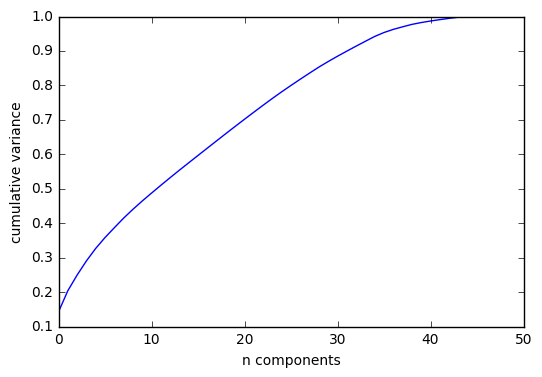

In [187]:
from sklearn.decomposition import PCA

pca = PCA(n_components=49, svd_solver='randomized')
model = pca.fit(x1)
cs = np.cumsum(model.explained_variance_ratio_)
plt.plot(cs)
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [188]:
from trainval import targets_str_to_indices

In [189]:
targets_indices_counts = Y[mask]['targets_str'].value_counts()
targets_indices_counts.index = targets_str_to_indices(targets_indices_counts.index)
print targets_indices_counts

[2]                                  75219
[2, 7]                                9663
[]                                    6007
[7]                                   5729
[2, 23]                               5081
[2, 12]                               2843
[12]                                  1762
[5]                                   1647
[2, 8]                                1528
[8]                                   1326
[4, 21, 22, 23]                       1311
[2, 11]                               1273
[4]                                   1039
[17]                                   934
[2, 12, 23]                            909
[2, 17]                                870
[4, 21, 22]                            851
[4, 23]                                763
[2, 7, 23]                             657
[2, 7, 11]                             610
[2, 19]                                609
[4, 12, 21, 22, 23]                    599
[2, 11, 12]                            587
[2, 17, 23]

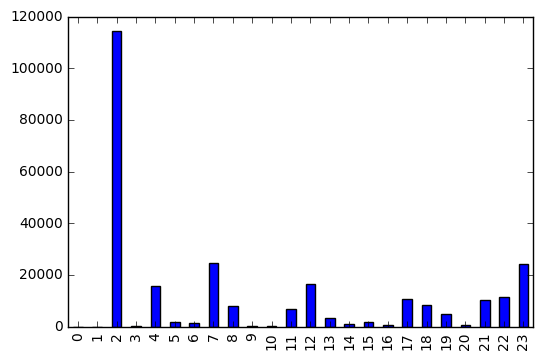

In [190]:
targets_index_counts = np.zeros((len(TARGET_LABELS)))
for i, c in enumerate(TARGET_LABELS):
    s = (Y[mask][c] > 0).sum()
    targets_index_counts[i] = s

targets_index_counts = pd.Series(targets_index_counts)
targets_index_counts.plot.bar()

Regroup indices such that the distribution is more less equalized

In [191]:
def flatten(array):
    out = []
    for item in array:
        out += item
    return out

In [348]:
base_1 = flatten([i for i in targets_indices_counts.index if len(i) == 1])
print base_1

base_1_mask = [len(i) == 1 for i in targets_indices_counts.index]
# print targets_indices_counts[base_1_mask]

base_2_mask = [len(i) == 2 for i in targets_indices_counts.index]
print targets_indices_counts[base_2_mask].shape
print targets_indices_counts[base_2_mask]


base_3_mask = [len(i) == 3 for i in targets_indices_counts.index]
print targets_indices_counts[base_3_mask].shape
print targets_indices_counts[base_3_mask]

[2, 7, 12, 5, 8, 4, 17, 6, 11, 18, 23, 15, 19, 16, 13, 20, 14, 3, 9, 0, 10, 22]
(115,)
[2, 7]      9663
[2, 23]     5081
[2, 12]     2843
[2, 8]      1528
[2, 11]     1273
[2, 17]      870
[4, 23]      763
[2, 19]      609
[2, 6]       431
[2, 13]      373
[2, 18]      365
[4, 12]      224
[11, 12]     204
[7, 17]      170
[2, 16]      123
[2, 20]      106
[7, 11]       99
[2, 15]       92
[4, 17]       92
[4, 7]        84
[7, 12]       76
[4, 22]       68
[12, 17]      53
[8, 17]       46
[7, 8]        44
[17, 23]      44
[4, 8]        43
[7, 20]       41
[2, 10]       40
[7, 13]       38
            ... 
[7, 10]        2
[5, 17]        2
[13, 16]       2
[11, 17]       2
[14, 23]       2
[17, 20]       2
[15, 23]       2
[6, 7]         2
[0, 2]         2
[8, 22]        1
[9, 11]        1
[14, 16]       1
[4, 14]        1
[3, 7]         1
[4, 16]        1
[14, 19]       1
[0, 15]        1
[7, 14]        1
[14, 15]       1
[4, 20]        1
[0, 4]         1
[6, 13]        1
[0, 19]     

Divide large groups by groups of length 2, 3 that already existing in the targets indices counts

In [289]:
def targets_indices_to_str(indices):
    out = np.zeros((24), dtype=np.int)
    out[indices] = 1
    return ''.join([str(i) for i in out])

In [313]:
targets_indices_2_3_mask = [0 < len(i) < 4 for i in targets_indices_counts.index]
targets_str_2_3_counts = targets_str_counts[targets_indices_2_3_mask]

In [288]:
from itertools import combinations

def divide(indices):
    """
    method to divide list of indices into groups of existing lists of size 2, 3
    
    :return: list of group if can be splitted
    None otherwise
    """
#     print "Divide : ", indices
    split = []
    for c in combinations(indices, 2):
#         print c
        c_str = targets_indices_to_str(list(c))
        if (targets_str_2_3_counts.index == c_str).sum() < 1:
            # Try another combination
            continue
        c1 = [i for i in indices if i not in c]
        if len(c1) > 3:
            s = divide(c1)
            if s is None:
                # Try another combination
                continue 
            split += [list(c)] + s
            break
        else:
            c1_str = targets_indices_to_str(c1)
            if (targets_str_2_3_counts.index == c1_str).sum() < 1:
                # Try another combination
                continue
            return [list(c), c1]
    
    if len(split) > 0:
        return split
    return None
    
        
count = 0
split_map = {}
for indices in targets_indices_counts.index:
    if len(indices) < 4:
        continue
        
    key = targets_indices_to_str(indices)
#     print indices, key
    split = divide(indices)
    
    if split is not None:
#         print "Add new split : ", indices, " -> ", split
        split_map[key] = split
    else:
        print "Failed to divide key/indices", indices, key
    
#     count += 1
#     if count == 20:
#         break

Failed to divide key/indices [4, 10, 21, 22] 000010000010000000000110
Failed to divide key/indices [3, 4, 12, 22] 000110000000100000000010
Failed to divide key/indices [3, 4, 22, 23] 000110000000000000000011
Failed to divide key/indices [3, 4, 12, 17, 23] 000110000000100001000001
Failed to divide key/indices [1, 2, 12, 23] 011000000000100000000001
Failed to divide key/indices [3, 4, 17, 18, 21, 22, 23] 000110000000000001100111
Failed to divide key/indices [2, 10, 11, 23] 001000000011000000000001
Failed to divide key/indices [2, 13, 20, 23] 001000000000010000001001
Failed to divide key/indices [3, 4, 8, 11, 12, 15] 000110001001100100000000
Failed to divide key/indices [2, 7, 13, 22] 001000010000010000000010
Failed to divide key/indices [4, 9, 12, 17, 18, 23] 000010000100100001100001
Failed to divide key/indices [3, 4, 12, 21, 22, 23] 000110000000100000000111
Failed to divide key/indices [4, 8, 9, 17, 18, 21, 22, 23] 000010001100000001100111
Failed to divide key/indices [4, 8, 10, 11, 13

In [336]:
division_2_3_groups = np.unique(targets_indices_counts[targets_indices_2_3_mask].index)
division_2_3_groups_str = [targets_indices_to_str(g) for g in division_2_3_groups]
print len(division_2_3_groups)
print division_2_3_groups[:10], division_2_3_groups_str[:10]

395
[[0] [0, 2] [0, 2, 7] [0, 2, 23] [0, 4] [0, 7] [0, 7, 8] [0, 15] [0, 19]
 [2]] ['100000000000000000000000', '101000000000000000000000', '101000010000000000000000', '101000000000000000000001', '100010000000000000000000', '100000010000000000000000', '100000011000000000000000', '100000000000000100000000', '100000000000000000010000', '001000000000000000000000']


In [337]:
def in_division_2_3_groups(indices):
    ind_str = targets_indices_to_str(indices)
    return ind_str in division_2_3_groups_str
    

def get_division_2_3_groups_index(indices):
    ind_str = targets_indices_to_str(indices)
    return division_2_3_groups_str.index(ind_str)


for vs in split_map.values():    
    for v in vs:
        assert in_division_2_3_groups(v)

In [360]:
targets_str_to_indices(['000010001000100100100111'])

array([[ 4,  8, 12, 15, 18, 21, 22, 23]])

In [359]:
targets_str_to_indices??

In [372]:
def targets_str_to_groups(targets_str):
    indices = targets_str_to_indices([targets_str])[0]
#     print "---> targets_str_to_groups : ", targets_str, indices
    if 0 < len(indices) < 4:
        if targets_str not in division_2_3_groups_str:
            print "!!! WTF : ", targets_str
        return division_2_3_groups_str.index(targets_str)
    if targets_str in split_map:
        split = split_map[targets_str]
        return [get_division_2_3_groups_index(i) for i in split]
    else:
        return None


In [373]:
data = np.zeros((Y[mask]['targets_str'].shape[0], len(division_2_3_groups)), dtype=np.int)
for i, targets_str in enumerate(Y[mask]['targets_str'].values):
    groups = targets_str_to_groups(targets_str)
    if groups is not None:
        data[i, groups] = 1

In [374]:
Y_groups = pd.DataFrame(data=data, columns=range(len(division_2_3_groups)))
Y_groups.index = Y[mask].index
Y_groups.head()
 

,0,1,2,3,4,5,6,7,8,9,...,385,386,387,388,389,390,391,392,393,394
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


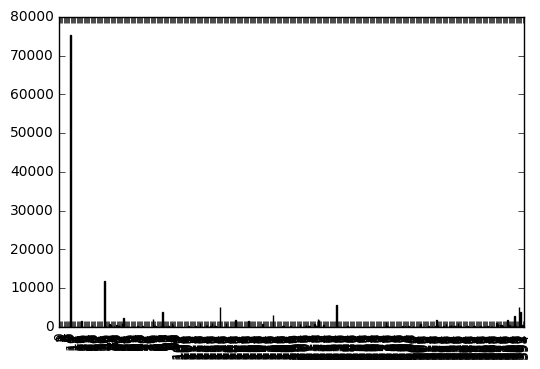

In [375]:
targets_groups_counts = np.zeros((len(division_2_3_groups)))
for i, c in enumerate(range(len(division_2_3_groups))):
    s = (Y_groups[c] > 0).sum()
    targets_groups_counts[i] = s

    
targets_groups_counts = pd.Series(targets_groups_counts)
targets_groups_counts.plot.bar()

In [377]:
division_2_3_groups[9]

[2]

In [226]:
targets_indices_with_2_mask = [2 in i for i in targets_indices_counts.index]
targets_indices_with_2 = targets_indices_counts[targets_indices_with_2_mask]
targets_indices_with_2

[2]                                          75219
[2, 7]                                        9663
[2, 23]                                       5081
[2, 12]                                       2843
[2, 8]                                        1528
[2, 11]                                       1273
[2, 12, 23]                                    909
[2, 17]                                        870
[2, 7, 23]                                     657
[2, 7, 11]                                     610
[2, 19]                                        609
[2, 11, 12]                                    587
[2, 17, 23]                                    583
[2, 7, 19]                                     510
[2, 6]                                         431
[2, 13]                                        373
[2, 18]                                        365
[2, 7, 17]                                     343
[2, 7, 12]                                     341
[2, 7, 13]                     

Visualize first most popular target classes

In [211]:
targets_str_counts = Y[mask]['targets_str'].value_counts()

In [225]:
targets_str_counts

001000000000000000000000    75219
001000010000000000000000     9663
000000000000000000000000     6007
000000010000000000000000     5729
001000000000000000000001     5081
001000000000100000000000     2843
000000000000100000000000     1762
000001000000000000000000     1647
001000001000000000000000     1528
000000001000000000000000     1326
000010000000000000000111     1311
001000000001000000000000     1273
000010000000000000000000     1039
000000000000000001000000      934
001000000000100000000001      909
001000000000000001000000      870
000010000000000000000110      851
000010000000000000000001      763
001000010000000000000001      657
001000010001000000000000      610
001000000000000000010000      609
000010000000100000000111      599
001000000001100000000000      587
001000000000000001000001      583
001000010000000000010000      510
001000100000000000000000      431
000000100000000000000000      405
001000000000010000000000      373
001000000000000000100000      365
00100001000000

In [216]:
def targets_str_to_class(targets_str, n_classes=20):
    indices = np.where(targets_str_counts.index == targets_str)[0]
    if len(indices) == 0:
        return -1
    index = indices[0]
    return index if index < n_classes-1 else n_classes

In [217]:
#Y1 = Y[mask]['targets_str'].apply(targets_str_to_class)

In [218]:
from sklearn.preprocessing import StandardScaler
from dataset import dummies_to_decimal

def prepare_to_fit_(X_train, Y_train):    
    x_train = X_train.values
    x_train = StandardScaler().fit_transform(x_train)
#     y_train = Y_train.apply(dummies_to_decimal, axis=1)
    y_train = Y_train.values    
    return x_train, y_train

In [220]:
X1, Y1 = X[mask][numerical_features], Y[mask]['targets_str'].apply(targets_str_to_class)
x1, y1 = prepare_to_fit_(X1, Y1)
print np.sum(y1 > 0), np.sum(y1 < 1), y1.shape

74761 75219 (149980,)


In [221]:
#x1_pca = pca.transform(x1)
x1_pca = x1
classes = np.unique(y1)

In [222]:
print x1_pca.shape, classes

(149980, 49) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20]


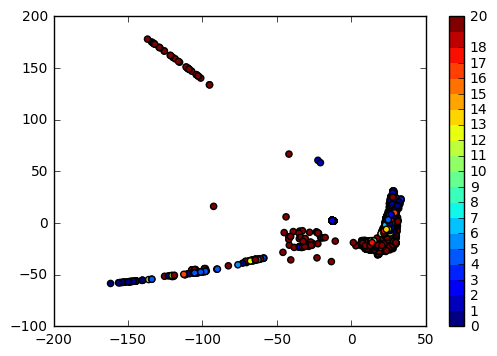

In [224]:
from sklearn.manifold import Isomap

data = x1_pca[::30]
targets = y1[::30]


model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=targets, cmap=plt.cm.get_cmap('jet', len(classes)))
plt.colorbar(ticks=classes)
# plt.clim(-0.5, 9.5);